In [1]:
import numpy as np
import os
import glob
import nibabel as nib
import sys
import json
import matplotlib.pyplot as plt
from pathlib import Path

sys.path.insert(0, str(Path(r'C:\Users\parkm\Desktop\github\ANALYSIS-NIFTI-FOR-DEEP-LEARNING\src\preprocessing.py').resolve().parent.parent))
sys.path.insert(0, str(Path(r'C:\Users\parkm\Desktop\github\ANALYSIS-NIFTI-FOR-DEEP-LEARNING\src\helper.py').resolve().parent.parent))
from src.helper import *
from src.eda_nifti import *
import sys


from itertools import product
from matplotlib import pyplot as plt


src.resampling을 이용해서 다음과 같이 리샘플링함

[resample_fixedsize_fixedspacing(nii_file, './result', sitk.sitkLinear, 128, [1,1,1]) for nii_file in nii_list]

In [2]:
nii_list = recursive_find_all_files(r'C:\Users\parkm\Desktop\github\ANALYSIS-NIFTI-FOR-DEEP-LEARNING\\notebooks\10.legion_boundary_difference\result', 'nii.gz')

In [3]:
nii_list

['C:\\Users\\parkm\\Desktop\\github\\ANALYSIS-NIFTI-FOR-DEEP-LEARNING\\\\notebooks\\10.legion_boundary_difference\\result\\derivatives\\sub-strokecase0050\\ses-0001\\sub-strokecase0050_ses-0001_msk.nii.gz',
 'C:\\Users\\parkm\\Desktop\\github\\ANALYSIS-NIFTI-FOR-DEEP-LEARNING\\\\notebooks\\10.legion_boundary_difference\\result\\derivatives\\sub-strokecase0051\\ses-0001\\sub-strokecase0051_ses-0001_msk.nii.gz',
 'C:\\Users\\parkm\\Desktop\\github\\ANALYSIS-NIFTI-FOR-DEEP-LEARNING\\\\notebooks\\10.legion_boundary_difference\\result\\derivatives\\sub-strokecase0052\\ses-0001\\sub-strokecase0052_ses-0001_msk.nii.gz',
 'C:\\Users\\parkm\\Desktop\\github\\ANALYSIS-NIFTI-FOR-DEEP-LEARNING\\\\notebooks\\10.legion_boundary_difference\\result\\rawdata\\sub-strokecase0050\\ses-0001\\sub-strokecase0050_ses-0001_adc.nii.gz',
 'C:\\Users\\parkm\\Desktop\\github\\ANALYSIS-NIFTI-FOR-DEEP-LEARNING\\\\notebooks\\10.legion_boundary_difference\\result\\rawdata\\sub-strokecase0050\\ses-0001\\sub-strokecase

In [4]:
matching_path_dict = get_matching_path_dict(nii_list, 'msk')

In [5]:
matching_path_dict_keys = [key for key in matching_path_dict.keys()]

### 1. 테스트 타겟: adc

In [6]:
matching_path_dict_keys[0]

'C:\\Users\\parkm\\Desktop\\github\\ANALYSIS-NIFTI-FOR-DEEP-LEARNING\\\\notebooks\\10.legion_boundary_difference\\result\\rawdata\\sub-strokecase0050\\ses-0001\\sub-strokecase0050_ses-0001_adc.nii.gz'

### 2. 테스트 타겟 라벨: msk

In [7]:
matching_path_dict[matching_path_dict_keys[0]]

'C:\\Users\\parkm\\Desktop\\github\\ANALYSIS-NIFTI-FOR-DEEP-LEARNING\\\\notebooks\\10.legion_boundary_difference\\result\\derivatives\\sub-strokecase0052\\ses-0001\\sub-strokecase0052_ses-0001_msk.nii.gz'

In [8]:
adc_nii = nib.load(matching_path_dict_keys[0])
adc_array = adc_nii.get_fdata()

In [9]:
adc_array.shape

(112, 112, 72)

In [10]:
mask_nii = nib.load(matching_path_dict[matching_path_dict_keys[0]])
mask_array = mask_nii.get_fdata()

In [11]:
mask_array.shape

(112, 112, 73)

### 3. 시각화 (생략)

In [12]:
from src.registration_metric import *

In [13]:
reg_check = RegistrationMetric()

In [14]:
reg_check.visuall_validation(matching_path_dict_keys[0], matching_path_dict[matching_path_dict_keys[0]])

ValueError: cannot find widget or abbreviation for argument: 'alpha'

In [ ]:
def display_images_with_alpha(image_z, alpha, fixed, moving):
    img = (1.0 - alpha)*fixed[:,:,image_z] + alpha*moving[:,:,image_z] 
    plt.imshow(sitk.GetArrayViewFromImage(img),cmap=plt.cm.Greys_r);
    plt.axis('off')
    plt.show()

In [ ]:
fixed_image = sitk.ReadImage(matching_path_dict_keys[0])
moving_image = sitk.ReadImage(matching_path_dict[matching_path_dict_keys[0]])

interact(display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2]-1), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_image))

In [ ]:
# skip visuallization

### 4. 차이나는 지표 찾기 

In [15]:
import numpy as np
import functools
import itertools as IT
import numpy as np
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage import morphology

In [16]:
N=10
array3d = np.zeros((N,)*3, dtype=int)

array3d[:,:,5] = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

array3d[:,:,6] = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

array3d[:,:,6] = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

array3d.shape

array3d[array3d==1] = 100

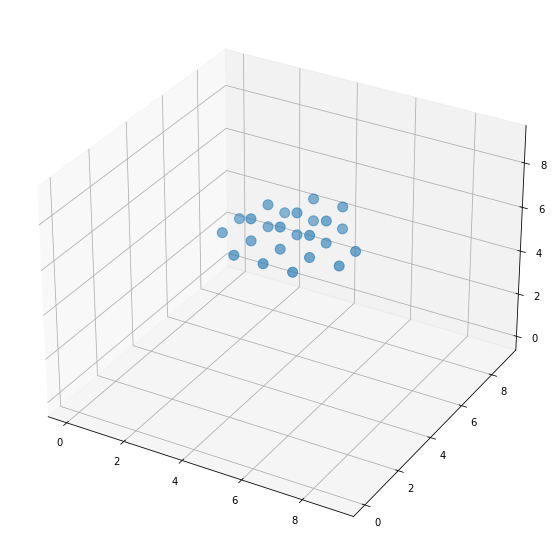

In [17]:
N = 10
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection="3d")
space = np.array([*product(range(N), range(N), range(N))]) # all possible triplets of numbers from 0 to N-1

array3d[array3d==1] = 100
volume = array3d # generate random data
ax.scatter(space[:,0], space[:,1], space[:,2], cmap=plt.get_cmap('Greys'), s=volume)

In [18]:
# dilation

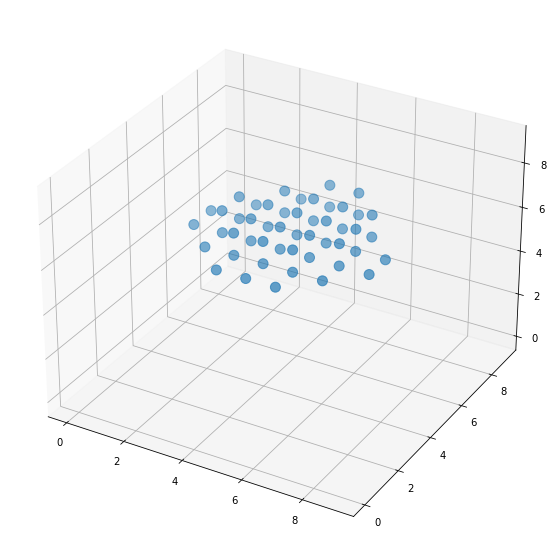

In [19]:
(x, y, z) = np.shape(array3d)
for slice_number in range(z):
    image_slice = array3d[:, :, slice_number]
    array3d[:, :, slice_number] = morphology.binary_dilation(image_slice, morphology.diamond(1))

# plot
array3d[array3d==1] = 100
N = 10
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection="3d")
space = np.array([*product(range(N), range(N), range(N))]) # all possible triplets of numbers from 0 to N-1

volume = array3d # generate random data
ax.scatter(space[:,0], space[:,1], space[:,2], cmap=plt.get_cmap('Greys'), s=volume)


In [20]:
#erosion

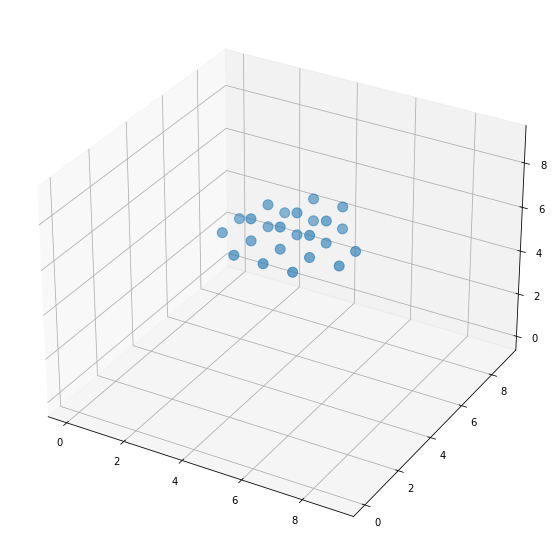

In [21]:
(x, y, z) = np.shape(array3d)
for slice_number in range(z):
    image_slice = array3d[:, :, slice_number]
    array3d[:, :, slice_number] = morphology.binary_erosion(image_slice, morphology.diamond(1))

# plot
array3d[array3d==1] = 100
N = 10
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection="3d")
space = np.array([*product(range(N), range(N), range(N))]) # all possible triplets of numbers from 0 to N-1

volume = array3d # generate random data
ax.scatter(space[:,0], space[:,1], space[:,2], cmap=plt.get_cmap('Greys'), s=volume)

In [22]:
## 함수화

In [23]:
def voxel_erosion(array3d):
    (x, y, z) = np.shape(array3d)
    for slice_number in range(z):
        image_slice = array3d[:, :, slice_number]
        array3d[:, :, slice_number] = morphology.binary_erosion(image_slice, morphology.diamond(1))
        
    return array3d

In [24]:
def voxel_dilation(array3d):
    (x, y, z) = np.shape(array3d)
    for slice_number in range(z):
        image_slice = array3d[:, :, slice_number]
        array3d[:, :, slice_number] = morphology.binary_dilation(image_slice, morphology.diamond(1))
        
    return array3d

In [25]:
## 테스트

In [26]:
adc_nii = nib.load(matching_path_dict_keys[0])
adc_array = adc_nii.get_fdata()

In [27]:
mask_nii = nib.load(matching_path_dict[matching_path_dict_keys[0]])
mask_array = mask_nii.get_fdata()

In [36]:
def get_boundary_diff_index(raw_nifti_file_path, mask_nifti_file_path):
    
    
    raw_nii = nib.load(raw_nifti_file_path)
    raw_nii_array = raw_nii.get_fdata()
    x,y,z = raw_nii_array.shape
    # raw_affine = raw_nii.affine
    
    mask_nii = nib.load(mask_nifti_file_path)
    mask_nii_array = mask_nii.get_fdata()
    mask_nii_array = mask_nii_array[:,:,:z]
    # mask_affine = mask_nii.affine
    
    eroded_mask = voxel_erosion(mask_nii_array)
    dilated_mask = voxel_dilation(mask_nii_array)
    
    
    out_boundary_mask = dilated_mask - mask_nii_array
    out_boundary_mask[out_boundary_mask<0] = 0
    
    inner_boundary_mask = mask_nii_array - eroded_mask
    
    out_boundary_val = raw_nii_array*out_boundary_mask
    inner_boundary_val = raw_nii_array*inner_boundary_mask
    
    boundary_diff_index = np.sum(out_boundary_val) - np.sum(inner_boundary_val)
        
    return mask_nii_array

In [39]:
mask_nii_array = get_boundary_diff_index(matching_path_dict_keys[0], matching_path_dict[matching_path_dict_keys[0]])

In [41]:
np.sum(mask_nii_array)

1832.0